# Captcha Solver Using SVM and LVQ-1 Algorithms

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/21zasker/Captcha-Solver/blob/main/Captcha_Solver.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/21zasker/Captcha-Solver/blob/main/Captcha_Solver.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

This notebook implements a text Captcha solver for alphanumeric characters using two machine learning approaches: a Support Vector Machine (SVM) model from the `sklearn` library and a custom-built Learning Vector Quantization 1 (LVQ-1) algorithm.

**What is a Support Vector Machine (SVM)?**

A Support Vector Machine (SVM) is a supervised machine learning algorithm used for classification and regression tasks. It works by finding the hyperplane that best separates the data into different classes. In the case of linear SVM, the algorithm seeks the optimal hyperplane that maximizes the margin between two classes of data points. Data points that are closest to this hyperplane are known as support vectors, and they play a crucial role in defining the decision boundary. SVMs are particularly effective in high-dimensional spaces and are robust to overfitting, especially in cases where the number of dimensions exceeds the number of samples.

**What is Learning Vector Quantization (LVQ)?**

Learning Vector Quantization (LVQ) is a vector-based supervised learning algorithm used for classification. LVQ works by learning a set of vectors that represent the different classes in the data. During training, each input sample is compared to these vectors, and the closest vector is updated to be more similar to the input sample if it belongs to the same class, or less similar if it belongs to a different class. LVQ-1 is the basic version of this algorithm, where the vectors are adjusted iteratively to better represent their respective classes. LVQ is particularly useful for problems where the data can be naturally clustered into distinct groups.

## Setup

### Import libraries

In [1]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score
from helpers import resize_to_fit, train_lvq, random_indexes, predict_lvq
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from IPython.display import Image, display
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from imutils import paths
import seaborn as sns
import pandas as pd
import numpy as np
import imutils
import os.path
import pickle
import cv2

### Dataset

The dataset consists of images with 4 alphanumeric characters, each split into individual character images. Said dataset is organized into folders by character class: one folder for each letter (e.g., 'A', 'B', 'C', etc.) and one for each number (e.g., '0', '1', '2', etc.). The total dataset includes 38,744 samples of letters and numbers.

The dataset preprocessing involves loading images, converting them to grayscale, resizing them to 20x20 pixels, and flattening them into 1D arrays. Labels are extracted based on folder names, and the image data is normalized to the range [0, 1]. The dataset is then split into training and testing sets. Labels are encoded numerically, and the encoder is saved for future use.

In [2]:
# Files with images and labels
LETTER_IMAGES_FOLDER = "extracted_letter_images"
MODEL_LABELS_FILENAME = "model_labels.dat" # To save label encoder
CAPTCHA_IMAGE_FOLDER = "generated_captcha_images"

In [3]:
# Initialize the data and labels
data = []
labels = []

# loop over the input images
for image_file in paths.list_images(LETTER_IMAGES_FOLDER):
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Resize the letter so it fits in a 20x20 pixel box
    image = resize_to_fit(image, 20, 20)

    # Flatten the image to a 1D array
    image = image.flatten()

    # Grab the name of the letter based on the folder it was in
    label = image_file.split(os.path.sep)[-2]

    # Add the letter image and it's label to our training data
    data.append(image)
    labels.append(label)

In [4]:
# Scale to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

# Split the training data into separate train and test sets
(X_train, X_test, Y_train, Y_test) = train_test_split(data, labels, test_size=0.2, random_state=42)

In [5]:
# Label Encoder
le = LabelEncoder()
Y_train = le.fit_transform(Y_train.ravel())
Y_test = le.transform(Y_test.ravel())

# Save the label encoder for future use
with open(MODEL_LABELS_FILENAME, "wb") as f:
    pickle.dump(le, f)

## Training the Models

### SVM Model

In [6]:
# SVM model
SVM_model = SVC(kernel="linear")
SVM_model.fit(X_train, Y_train)

SVC(kernel='linear')

In [7]:
# Predictions
Y_pred_svm = SVM_model.predict(X_test)

Accuracy on test data: 99.65%

Average Precision: 99.65%

Average Recall: 99.65%



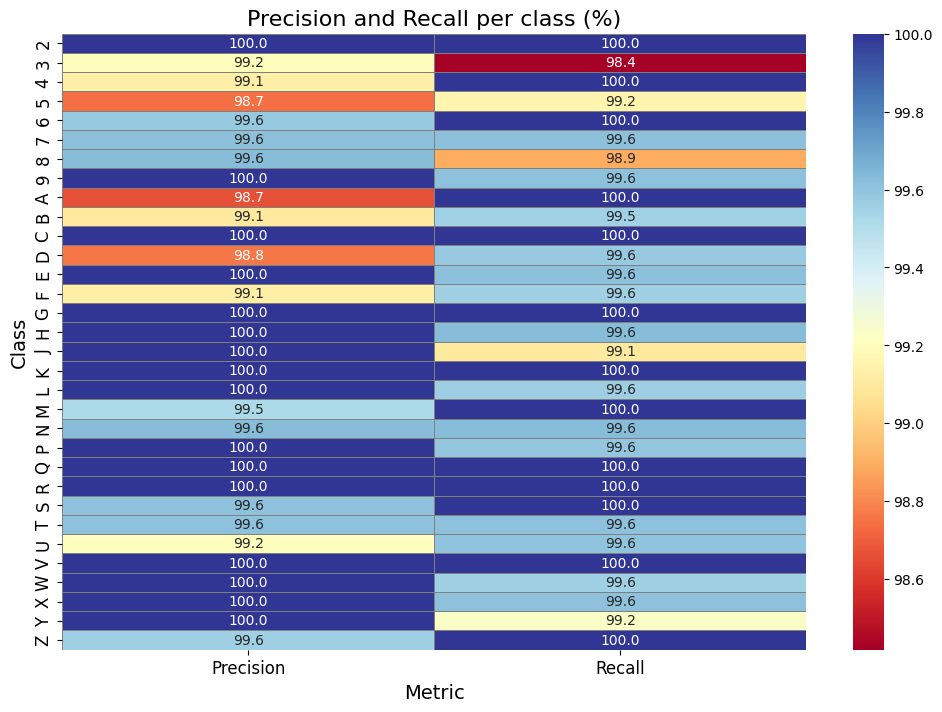

In [8]:
# Average precision and recall
accuracy = accuracy_score(Y_test, Y_pred_svm)
average_precision = precision_score(Y_test, Y_pred_svm, average='weighted')
average_recall = recall_score(Y_test, Y_pred_svm, average='weighted')

# Precision and recall per class
precision_values = precision_score(Y_test, Y_pred_svm, average=None)
recall_values = recall_score(Y_test, Y_pred_svm, average=None)

# Decoded class names
class_names = le.classes_

# Print average metrics
print(f'Accuracy on test data: {accuracy * 100:.2f}%\n')
print(f'Average Precision: {average_precision * 100:.2f}%\n')
print(f'Average Recall: {average_recall * 100:.2f}%\n')

# Create a DataFrame for the heatmap
data = pd.DataFrame({
    'Precision': precision_values,
    'Recall': recall_values
}, index=class_names)

# Plotting heatmap to showcase precision and recall per class
plt.figure(figsize=(12, 8))
sns.heatmap(data * 100, annot=True, fmt='.1f', cmap='RdYlBu', cbar=True, linewidths=0.5, linecolor='gray')
plt.title('Precision and Recall per class (%)', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Class', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### LVQ Model

Algorithm: Initially, vectors are randomly selected from the training data to represent each class. During training, each data point is compared to these class vectors by calculating distances. The closest vector (winner) is updated: if the data point's label matches the class of the winner, the vector moves closer to the data point; otherwise, it moves away. This adjustment process aligns the vectors with their classes. 

The implementation of this LVQ model can be found in the `helpers.py` file. It includes the following functions:

- `random_indexes`: Selects random data points to initialize class vectors.
- `train_lvq`: Trains the LVQ model by adjusting class vectors based on their proximity to data points.
- `predict_lvq`: Classifies test samples by determining their closest class vector.

In [9]:
# Total number of labels
num_classes = len(np.unique(labels))

# Total of neurons and inputs
num_neurons = num_classes
num_inputs = X_train.shape[1]

# Inicialize vectors
classes = random_indexes(num_classes, Y_train)
vectors = np.array([X_train[class_index] for class_index in classes])

# Learning rate and number of epochs
lr = 0.1
num_epochs = 100

# Train LVQ
final_vectors = train_lvq(num_neurons, vectors, X_train, lr, Y_train)

In [10]:
# Predictions
Y_pred_lvq = predict_lvq(X_test, final_vectors)

Accuracy on test data: 92.27%

Average Precision: 92.64%

Average Recall: 92.27%



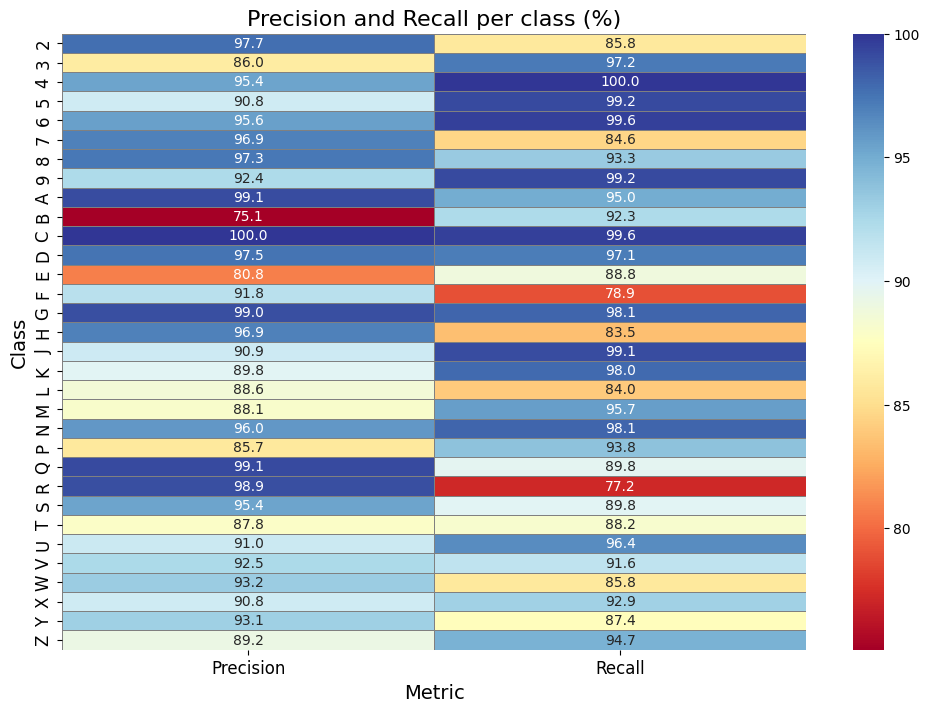

In [11]:
# Average precision and recall
accuracy = accuracy_score(Y_test, Y_pred_lvq)
average_precision = precision_score(Y_test, Y_pred_lvq, average='weighted')
average_recall = recall_score(Y_test, Y_pred_lvq, average='weighted')

# Precision and recall per class
precision_values = precision_score(Y_test, Y_pred_lvq, average=None)
recall_values = recall_score(Y_test, Y_pred_lvq, average=None)

# Decoded class names
class_names = le.classes_

print(f'Accuracy on test data: {accuracy * 100:.2f}%\n')
print(f'Average Precision: {average_precision * 100:.2f}%\n')
print(f'Average Recall: {average_recall * 100:.2f}%\n')

# Create a DataFrame for the heatmap
data = pd.DataFrame({
    'Precision': precision_values,
    'Recall': recall_values
}, index=class_names)

# Plotting heatmap to showcase precision and recall per class
plt.figure(figsize=(12, 8))
sns.heatmap(data * 100, annot=True, fmt='.1f', cmap='RdYlBu', cbar=True, linewidths=0.5, linecolor='gray')
plt.title('Precision and Recall per class (%)', fontsize=16)
plt.xlabel('Metric', fontsize=14)
plt.ylabel('Class', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

### t-SNE

**What is t-SNE?**

t-SNE (t-distributed Stochastic Neighbor Embedding) is a dimensionality reduction technique primarily used for visualizing high-dimensional data in a lower-dimensional space, typically 2D or 3D. It is particularly effective for preserving the local structure of data, making it easier to visualize and understand the relationships between data points.

The main idea behind t-SNE is to convert the similarity between data points into probabilities and then attempt to map these probabilities into a lower-dimensional space in such a way that similar points stay close together, while dissimilar points remain farther apart.

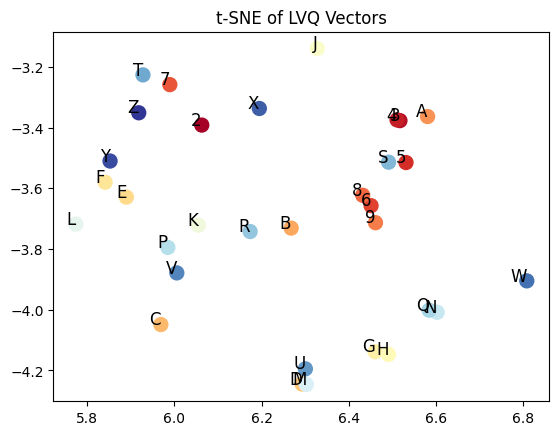

In [16]:
# Class labels for each vector
class_names = le.classes_

# Apply t-SNE to the final LVQ vectors
tsne = TSNE(n_components=2, random_state=42)
lvq_tsne = tsne.fit_transform(final_vectors)

# Extract t-SNE components
tsne_x = lvq_tsne[:, 0]
tsne_y = lvq_tsne[:, 1]

# Create the plot
fig, ax = plt.subplots()
scatter = ax.scatter(tsne_x, tsne_y, c=np.arange(len(class_names)), cmap="RdYlBu", s=100)

# Annotate each point with its class name
for i, (x, y) in enumerate(zip(tsne_x, tsne_y)):
    ax.text(x, y, class_names[i], fontsize=12, ha='right')

# Add title and show
ax.set_title("t-SNE of LVQ Vectors")
plt.show()

**Observations with LVQ Vectors**

The t-SNE plot shows that vectors for visually similar classes are positioned close to each other. For example, the vector for the letter "S" is near the vector for the number "5". This proximity reflects the visual similarity between "S" and "5" in captcha images, which leads to the vectors being adjusted closer during training. This clustering indicates that these classes share visual features that are captured in the vector space.

## Testing and Results

In [13]:
# Load up the model labels (so we can translate model predictions to actual letters)
with open(MODEL_LABELS_FILENAME, "rb") as f:
    le = pickle.load(f)

In [14]:
# Random CAPTCHA images to test
captcha_image_files = list(paths.list_images(CAPTCHA_IMAGE_FOLDER))
captcha_image_files = np.random.choice(captcha_image_files, size=(10,), replace=False)

Choose the model (1 for SVM, 2 for LVQ-1): 1

CAPTCHA text is: CTAK


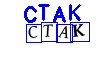

CAPTCHA text is: XD8B


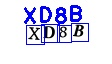

CAPTCHA text is: XAMJ


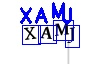

CAPTCHA text is: E89Y


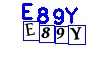

CAPTCHA text is: TRH2


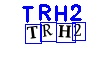

CAPTCHA text is: 538S


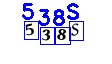

CAPTCHA text is: N5R5


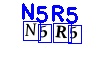

CAPTCHA text is: MJVL


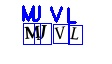

CAPTCHA text is: LFT5


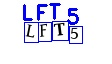

CAPTCHA text is: JEQ8


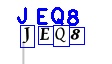

In [15]:
# User input to choose the model
model_choice = int(input("Choose the model (1 for SVM, 2 for LVQ-1): "))
print()

# loop over the image paths
for image_file in captcha_image_files:
    # Load the image and convert it to grayscale
    image = cv2.imread(image_file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Extra padding around the image
    image = cv2.copyMakeBorder(image, 20, 20, 20, 20, cv2.BORDER_REPLICATE)

    # Convert it to pure black and white
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]

    # Find the contours (continuous blobs of pixels) the image
    contours = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = contours[1] if imutils.is_cv3() else contours[0]

    letter_image_regions = []

    # Loop through each of the four contours and extract the letter inside of each one
    for contour in contours:
        # Get the rectangle that contains the contour
        (x, y, w, h) = cv2.boundingRect(contour)

        # If countour is too wide to be a single letter split it in half
        # for two letter regions
        if w / h > 1.25:
            half_width = int(w / 2)
            letter_image_regions.append((x, y, half_width, h))
            letter_image_regions.append((x + half_width, y, half_width, h))
        else:
            #  Letter by itself
            letter_image_regions.append((x, y, w, h))

    # Skip the image if it doesn't have 4 letters in the captcha
    if len(letter_image_regions) != 4:
        continue

    # Sort the letter images to process them from left-to-right
    letter_image_regions = sorted(letter_image_regions, key=lambda x: x[0])

    # Output image
    output = cv2.merge([image] * 3)
    # List for predicted letters
    predictions = []

    # loop over the letters
    for letter_bounding_box in letter_image_regions:
        # Coordinates of the letter
        x, y, w, h = letter_bounding_box

        # Extract letter from with a 2-pixel margin around the edge
        letter_image = image[y - 2:y + h + 2, x - 2:x + w + 2]

        # Re-size the letter image to 20x20 pixels to match training data
        letter_image = resize_to_fit(letter_image, 20, 20)
        letter_image = letter_image.flatten()
        letter_image = letter_image / 255.0

        # Models prediction based on user input
        if model_choice == 1:
            prediction = SVM_model.predict(letter_image.reshape(1, -1))
        elif model_choice == 2:
            distances = np.linalg.norm(final_vectors - letter_image.reshape(1, -1), axis=1)
            prediction = np.argmin(distances)
        else:
            print("Invalid model choice. Please choose 'SVM' or 'LVQ-1'.")

        # Convert the encoded prediction back to a normal letter
        prediction = le.inverse_transform(prediction.ravel())
        letter = str(prediction[0])
        predictions.append(letter)

        # draw the prediction on the output image
        cv2.rectangle(output, (x - 2, y - 2), (x + w + 4, y + h + 4), (255, 0, 0), 1)
        cv2.putText(output, letter, (x - 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.65, (255, 0, 0), 2)

    # Print the captcha's text
    captcha_text = "".join(predictions)
    print("CAPTCHA text is: {}".format(captcha_text))

    # Save the annotated image
    output_filename = "output_image.jpg"
    cv2.imwrite(output_filename, output)
    
    # Display the annotated image in the notebook
    display(Image(filename=output_filename))